In [3]:
#our handpicked initial columns that we want to look at

desired_col=np.array(['id','zipcode','description','host_is_superhost','neighbourhood_cleansed','neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type', 'price','weekly_price', 'monthly_price','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','number_of_reviews','first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'longitude', 'latitude'])


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import locale
import os
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split


In [4]:
print(desired_col)

['id' 'zipcode' 'description' 'host_is_superhost' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'price' 'weekly_price'
 'monthly_price' 'cleaning_fee' 'guests_included' 'extra_people'
 'minimum_nights' 'availability_30' 'availability_60' 'availability_90'
 'availability_365' 'number_of_reviews' 'first_review' 'last_review'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'calculated_host_listings_count'
 'reviews_per_month' 'longitude' 'latitude']


In [695]:
#get airbnb date pairs for 1 year difference 

airbnb_files = sorted(os.listdir('./Data/NYC_full_listings'))
airbnb_files_monthyear = []
for i in range(len(airbnb_files)):
    year = int(airbnb_files[i].split('_')[0])
    month = (airbnb_files[i].split('_')[1][:-4])
    airbnb_files_monthyear.append((month, year))


airbnb_files_datePairs = []
for i,date in enumerate(airbnb_files_monthyear):
    if (date[0], date[1]+1) in airbnb_files_monthyear:
        index_next_yr = airbnb_files_monthyear.index((date[0], date[1]+1))
        airbnb_files_datePairs.append((airbnb_files[i], airbnb_files[index_next_yr]))
print(len(airbnb_files_datePairs))
print(airbnb_files_datePairs)

29
[('2015_01.csv', '2016_01.csv'), ('2015_05.csv', '2016_05.csv'), ('2015_06.csv', '2016_06.csv'), ('2015_08.csv', '2016_08.csv'), ('2015_09.csv', '2016_09.csv'), ('2015_10.csv', '2016_10.csv'), ('2015_11.csv', '2016_11.csv'), ('2015_12.csv', '2016_12.csv'), ('2016_01.csv', '2017_01.csv'), ('2016_02.csv', '2017_02.csv'), ('2016_04.csv', '2017_04.csv'), ('2016_05.csv', '2017_05.csv'), ('2016_06.csv', '2017_06.csv'), ('2016_07.csv', '2017_07.csv'), ('2016_08.csv', '2017_08.csv'), ('2016_09.csv', '2017_09.csv'), ('2016_10.csv', '2017_10.csv'), ('2016_11.csv', '2017_11.csv'), ('2016_12.csv', '2017_12.csv'), ('2017_01.csv', '2018_01.csv'), ('2017_02.csv', '2018_02.csv'), ('2017_03.csv', '2018_03.csv'), ('2017_04.csv', '2018_04.csv'), ('2017_05.csv', '2018_05.csv'), ('2017_06.csv', '2018_06.csv'), ('2017_07.csv', '2018_07.csv'), ('2017_08.csv', '2018_08.csv'), ('2017_09.csv', '2018_09.csv'), ('2017_10.csv', '2018_10.csv')]


In [729]:
def fix_columns(df, desired_col):
    for col in desired_col:
        #print(col)
        df_col = df.loc[:, col]
        if df_col.dtype == 'object':
            if len(df_col) > 0:
                #print(col, df_col.iloc[0], type(df_col.iloc[0]))
                j = 0
                while type(df_col.iloc[j]) is float:
                    j += 1
                if df_col.iloc[j][0] =="$":
                    df_col = df_col.fillna("$-1.00")
                    new_col = [locale.atof(x[1:]) for x in df_col]
                    df.loc[:,col] = new_col
                elif df_col.iloc[0] == 'f' or df_col.iloc[0] == 't':
                    new_col = [(x=='t') for x in df_col]
                    df.loc[:,col] = new_col
        if col == "neighbourhood_cleansed" or col == "neighbourhood_group_cleansed":
            new_col = [str(x).lower() for x in df_col]
            df.loc[:,col] = new_col
    return df
def fix_zillow_regionname_countyname(df):
    for x in ["RegionName", "CountyName"]:
        df_col = df.loc[:,x]
        new_col = [str(x).lower() for x in df_col]
        df.loc[:,x] = new_col
    return df

#goes through all zillow data and airbnb dataframe for date pair, finds neighborhoods (neighborhood + county pair)
#that are in both data sets and counts how many listings for that neighborhood for each # bedrooms between 0 and 2
#returns list with tuple, where tuple contains matching neighborhood/county sets and a list of bools per bedroom number checking if there are enough listings 
def find_common_neigh(zillow_df, airbnb_df_prev, airbnb_df_curr):
    both_neighs = []
    airbnb_set_prev = set([(x,y) for x,y in zip(airbnb_df_prev["neighbourhood_cleansed"], airbnb_df_prev["neighbourhood_group_cleansed"])])
    airbnb_set_curr = set([(x,y) for x,y in zip(airbnb_df_curr["neighbourhood_cleansed"], airbnb_df_curr["neighbourhood_group_cleansed"])])
    zillow_set = set([(x,y) for x,y in zip(zillow_df["RegionName"],zillow_df["CountyName"])])
    for z, z_c in zillow_set:
        for a, a_c in airbnb_set_curr:
            if z.lower() == a.lower() and (z_c.lower() == a_c.lower() or a_c.lower() == 'nan'):
                for a_p, a_p_c in airbnb_set_prev:
                    if z.lower() == a_p.lower() and (z_c.lower() == a_p_c.lower() or a_p_c.lower() == 'nan'):
                        enough_pts_prev = [len(airbnb_df_prev.loc[(airbnb_df_prev['bedrooms'] == x)&(airbnb_df_prev['neighbourhood_cleansed'] == a)])>30 for x in range(3)]
                        enough_pts_curr = [len(airbnb_df_curr.loc[(airbnb_df_curr['bedrooms'] == x)&(airbnb_df_curr['neighbourhood_cleansed'] == a)])>30 for x in range(3)]
                        enough_pts = [(x&y) for x,y in zip(enough_pts_prev,enough_pts_curr)]
                        both_neighs.append((a.lower(), z_c.lower(), enough_pts))
    return both_neighs

def get_airbnb_county_from_lon_lat(df):
    pass

In [713]:
yr,prev_yr = read_in_airbnb_file_pair(airbnb_files_datePairs[-10], desired_col)
print(set(yr.loc[:,"neighbourhood_group_cleansed"]))

print(set(yr.loc[:,"room_type"]))

/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (40,85) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [874]:
yr,prev_yr = read_in_airbnb_file_pair(airbnb_files_datePairs[-10], desired_col)
print(yr.loc[yr['price']==0])
print(yr.loc[yr['price']==0]['price'])
for i in range(len(yr.loc[yr['price']==0])):
    print(yr.loc[yr['price']==0].iloc[i]['description'])

/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


             id zipcode                                        description  \
3593   22485974   11217  Bright and beautiful one bedroom in lovely Boe...   
7059   20586622   11237  New place at bushwick It’s the greatest place ...   
8210   20688624   10011  A charming alcove studio apartment in the hear...   
14821  21518548   10009  Welcome to your warm, earthy yet minimalist on...   
15209  20326257   10003  Studio apartment in the heart of the East Vill...   
15394  21369333   10003  This beautiful and sunny first floor EV 1 bedr...   
20653  20224936   11222  This store-front style studio is located at st...   
23619  20033323   10031  Beautiful private duplex unit in Harlem. Windi...   
23998  21489060   10027  Luxury in NYC. Gorgeous fully modern condo in ...   
28946  20455626   10002  Located on one of the few tree lined streets a...   
29737  20570245   10001  Beautifully renovated 2 Bedroom 1 Bath Corner ...   
29791  20933849   10022  It's my first doing it in NYC. It's all

In [871]:
yr,prev_yr = read_in_airbnb_file_pair(airbnb_files_datePairs[5], desired_col)
print(set(yr.loc[:,"price"]))

print(set(yr.loc[:,"room_type"]))

/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


{10.0, 14.0, 30.0, 33.0, 34.0, 35.0, 39.0, 40.0, 41.0, 42.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 2100.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 180.0, 181.0, 182.0, 183.0, 184.0, 185.0,

In [649]:
zillow_files = pd.read_csv("Data/zillow_0_1_2_combined.csv")
zillow_files = fix_zillow_regionname_countyname(zillow_files)
test_neighs = find_common_neigh(zillow_files, prev_yr, yr)
print(np.sum([np.sum(neigh[2]) for neigh in test_neighs]))
zillow_columns = list(zillow_files.columns)
zillow_columns_fix = {}
for x in zillow_columns:
    new_x = x.replace('-', '_').replace('NumBeds', 'bedrooms')
    zillow_columns_fix[x] = new_x
zillow_files = zillow_files.rename(columns = zillow_columns_fix)
print(zillow_files.columns)


87
Index(['Unnamed: 0', '2010_02', '2010_03', '2010_04', '2010_05', '2010_06',
       '2010_07', '2010_08', '2010_09', '2010_10',
       ...
       '2018_07', '2018_08', '2018_09', 'City', 'CountyName', 'Metro',
       'bedrooms', 'RegionName', 'SizeRank', 'State'],
      dtype='object', length=112)


In [809]:
desired_col_aggregate_quants =np.array(['minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'number_of_reviews','reviews_per_month'])

In [956]:
def get_zillow_dates(date_pair, num_months_predict, zillow_lag):
        date = date_pair[1][:-4].split('_')
        adj_num_months = num_months_predict - 1 
        adj_zillow_lag = zillow_lag + 1
        z_date = [int(x) for x in date]
        z_date = [z_date[0]+int((z_date[1]+adj_num_months)/12),(z_date[1]+adj_num_months)%12 + 1]
        z_prev_date_mon = (z_date[1] - adj_zillow_lag)
        year_adj = z_prev_date_mon < 0
        z_prev_date = [z_date[0]-year_adj, z_prev_date_mon%12 + 1]
        date = str(z_date[0])+"_"+str(z_date[1]).zfill(2)
        prev_date = str(z_prev_date[0])+"_"+str(z_prev_date[1]).zfill(2)
        return prev_date, date
    
def get_zillow_rel_change_rent(zillow_files_bd_neigh, prev_date, date):
    zillow_rents = zillow_files_bd_neigh.iloc[0]
    #print(zillow_rents)
    return (zillow_rents[date]-zillow_rents[prev_date])/zillow_rents[prev_date]

def get_rel_num_same_listings(prev_yr, yr): #returns fraction of prev yr ids that persisted to the following yr
    prev_yr_ids = list(prev_yr.loc[:, "id"])
    yr_ids = list(yr.loc[:, "id"])
    return np.sum([i in yr_ids for i in prev_yr_ids])/len(prev_yr_ids)

def get_rel_change_in_numlistings(prev_yr, yr):
    return (len(yr)-len(prev_yr))/len(prev_yr)

def get_change_in_frac_prof_listings(prev_yr,yr):
    prof_prev = len(prev_yr.loc[prev_yr['calculated_host_listings_count']>1])
    prof_yr = len(yr.loc[yr['calculated_host_listings_count']>1])
    return (prof_yr/len(yr))-(prof_prev/len(prev_yr))

def get_change_in_frac_superhosts(prev_yr,yr):
    prev_frac = np.sum(prev_yr.loc[:,'host_is_superhost'])/len(prev_yr)
    curr_frac = np.sum(yr.loc[:,'host_is_superhost'])/len(yr)
    #print("frac suphost:", prev_frac, curr_frac)
    return prev_frac-curr_frac

def get_change_in_frac_monweeprice(prev_yr, yr):
    results = []
    for curr in (prev_yr, yr):
        tot_with_price = 0
        #print(curr.loc[:,'weekly_price'])
        #print(curr.loc[:,'monthly_price'])
        for i in range(len(curr)):
            if curr.loc[:,'weekly_price'].iloc[i] != -1 or curr.loc[:,'monthly_price'].iloc[i] != -1:
                tot_with_price += 1
        results.append(tot_with_price/len(curr))
    #print("Mon/Wee results:", results)
    return results[1]-results[0]
        

def get_rel_change_in_mean_feats(prev_yr,yr,feats):
    rel_change = []
    for f in feats:
        prev_mean = np.mean(prev_yr.loc[:,f])
        yr_mean = np.mean(yr.loc[:,f])
        rel_change.append((yr_mean-prev_mean)/prev_mean)
    return rel_change

def get_rel_change_in_adjprice(prev_yr,yr):
    prev_curr_median_prices = []
    for y in (prev_yr,yr):
        y_prices = []
        for i in range(len(y)):
            curr_list = y.iloc[i]
            num_adtl_occ = max((min((2 + curr_list['bedrooms']), curr_list['accommodates'])-curr_list['guests_included']), 0)
            adj_price = curr_list["price"] + num_adtl_occ*curr_list["extra_people"] + curr_list["cleaning_fee"]
            y_prices.append(adj_price)
        prev_curr_median_prices.append(np.median(y_prices))
    return (prev_curr_median_prices[1]-prev_curr_median_prices[0])/prev_curr_median_prices[0]

def get_rel_change_in_dif_adjprice_listedprice(prev_yr,yr):
    prev_curr_median_prices = []
    for y in (prev_yr,yr):
        y_prices = []
        for i in range(len(y)):
            curr_list = y.iloc[i]
            num_adtl_occ = max((min((2 + curr_list['bedrooms']), curr_list['accommodates'])-curr_list['guests_included']), 0)
            adj_price = ((curr_list["price"] + num_adtl_occ*curr_list["extra_people"] + curr_list["cleaning_fee"])- curr_list['price'])/curr_list['price']
            if np.isnan(adj_price):
                print(curr_list["price"])
            y_prices.append(adj_price)
        #print(y_prices)
        prev_curr_median_prices.append(np.median(y_prices))
    if np.isnan(prev_curr_median_prices[1]-prev_curr_median_prices[0]):
        if np.isnan(prev_curr_median_prices[0]):
            print('Prev is nan')
            #print(set(prev_yr['accommodates']))
        else:
            print('Curr is nan')
            #print(set(yr['accommodates']))
    return prev_curr_median_prices[1]-prev_curr_median_prices[0]

def get_rel_change_in_medianprice(prev_yr, yr):
    return (np.median(yr.loc[:,'price'])-np.median(prev_yr.loc[:, 'price']))/np.median(prev_yr.loc[:, 'price'])

def get_rel_change_avg_age(prev_yr, yr, zero_date): #age calculated from date of first review
    first_revs = (list(prev_yr.loc[:, 'first_review']),list(yr.loc[:, 'first_review']))
    final_dates = [[],[]]
    for i,yr_list in enumerate(first_revs):
        for date in yr_list:
            if type(date) is str:
                curr_date = [int(x) for x in date.split('-')]
                curr_date_rel = (curr_date[0]-zero_date[0], curr_date[1]+int(curr_date[2]/16)-zero_date[1])
                curr_date_int = curr_date_rel[0]*12 + curr_date_rel[1]
                final_dates[i].append(curr_date_int)
            else:
                final_dates[i].append(0)
    return (np.mean(final_dates[1]) - np.mean(final_dates[0]))/np.mean(final_dates[0])

def get_curr_date_as_int(zero_date, date):
    if date == zero_date:
        return 0
    curr_date = [int(x) for x in date.split('_')]
    curr_date_rel = (curr_date[0]-zero_date[0], curr_date[1]-zero_date[1])
    curr_date_int = curr_date_rel[0]*12 + curr_date_rel[1]
    return curr_date_int

def get_rel_change_mean_descr_len(prev_yr, yr):
    results = []
    for curr in (prev_yr, yr):
        all_curr = []
        for i in range(len(curr)):
            #print(curr['description'].iloc[i])
            #print(curr_descr_len)
            all_curr.append(len(curr['description'].iloc[i]))
        results.append(np.mean(all_curr))
    return (results[1]-results[0])/results[1]
    
def get_all_features(bedrooms, prev_yr, yr, feats, zero_date, date): #feats is the list of features that are used as is, just take rel change in their means
    feat_set = [bedrooms, get_curr_date_as_int(zero_date, date),get_rel_num_same_listings(prev_yr, yr),get_rel_change_in_numlistings(prev_yr, yr),get_rel_change_in_medianprice(prev_yr, yr),get_rel_change_in_adjprice(prev_yr, yr),get_rel_change_in_dif_adjprice_listedprice(prev_yr,yr),get_change_in_frac_monweeprice(prev_yr, yr), get_change_in_frac_prof_listings(prev_yr, yr),get_rel_change_avg_age(prev_yr, yr, zero_date),get_rel_change_mean_descr_len(prev_yr, yr),get_change_in_frac_superhosts(prev_yr,yr),]
    feat_set.extend(get_rel_change_in_mean_feats(prev_yr,yr,feats))
    return np.array(feat_set)

def get_final_feature_set(date_prev_yr_df, date_yr_df, feats, all_date_pts_feats, zero_date):
    final = []
    for bedrooms in range(3):
        all_pts = []
        for pt in all_date_pts_feats:
            if pt[0] == bedrooms:
                all_pts.append(pt)
        prev_set = date_prev_yr_df.loc[date_prev_yr_df['bedrooms']==bedrooms]
        curr_set = date_yr_df.loc[date_yr_df['bedrooms']==bedrooms]
        date_feats = get_all_features(0, prev_set, curr_set, feats, zero_date, zero_date)
        all_pts_adj = np.array([pt-date_feats for pt in all_pts])
        #print(final, all_pts_adj)
        #final = np.concatenate((final, all_pts_adj), axis=0)
        final.extend(all_pts_adj)
    return final
        
    
def create_labeled_set_regression(date_pairs, zillow_files, desired_col, feats, num_months_predict, zillow_lag):
    all_pts_feats = []
    all_pts_y = []
    zero_date = (2010, 1)
    for pair in date_pairs: #go through the airbnb date pairs
        prev_date, date = get_zillow_dates(pair, num_months_predict, zillow_lag)
        print(pair,prev_date,date)
        if date in list(zillow_files.columns):
            print('found')
            date_feats = []
            yr, prev_yr = read_in_airbnb_file_pair(pair, desired_col)
            both_neighs = find_common_neigh(zillow_files, prev_yr, yr)
            date_yr_df = pd.DataFrame( columns = yr.columns) #will be used to store all dfs from yr for this date pair
            date_prev_yr_df = pd.DataFrame( columns = yr.columns) #will be used to store all dfs from prev_yr for this date pair
            for neigh in both_neighs:
                for bedrooms, enough in enumerate(neigh[2]):
                    if enough:
                        zillow_files_bd_neigh = zillow_files.loc[(zillow_files["bedrooms"]==bedrooms)&(zillow_files["RegionName"]==neigh[0])&(zillow_files["CountyName"]==neigh[1])]
                        zillow_files_bd_neigh = zillow_files_bd_neigh.loc[:, [prev_date, date]]
                        if len(zillow_files_bd_neigh) > 0:
                            enough_zillow_data = [x != 0 for x in zillow_files_bd_neigh.iloc[0]]
                            if np.sum(enough_zillow_data) >= 2:
                                y_val = get_zillow_rel_change_rent(zillow_files_bd_neigh, prev_date, date)
                                yr_bd_neigh = yr.loc[(yr['bedrooms'] == bedrooms)&(yr['neighbourhood_cleansed'] == neigh[0])&(yr['neighbourhood_group_cleansed'] == neigh[1])]
                                prev_yr_bd_neigh = prev_yr.loc[(prev_yr['bedrooms'] == bedrooms)&(prev_yr['neighbourhood_cleansed'] == neigh[0])&(prev_yr['neighbourhood_group_cleansed'] == neigh[1])]
                                date_yr_df = pd.concat([date_yr_df,yr_bd_neigh])
                                date_prev_yr_df = pd.concat([date_prev_yr_df,prev_yr_bd_neigh])
                                curr_features = get_all_features(bedrooms,prev_yr_bd_neigh, yr_bd_neigh, feats, zero_date, date)
                                date_feats.append(curr_features)
                                all_pts_y.append(y_val)
            all_pts_feats.extend(get_final_feature_set(date_prev_yr_df, date_yr_df, feats, date_feats, zero_date))
            print(len(all_pts_feats), len(all_pts_y))
    return np.array(all_pts_feats), np.array(all_pts_y)
                                
def convert_regression_ys_to_classes(y_vals, y_class_cutoffs, y_classes):
    new_y_vals = []
    
    for y in y_vals:
        for i, c in enumerate(y_class_cutoffs):
            if y < c:
                new_y_vals.append(y_classes[i])
                break
    '''         
    for y in y_vals:
        new_y = round(y*100)
        if new_y > 10:
            new_y = 11
        elif new_y < -10:
            new_y = -11
        new_y_vals.append(int(new_y/10))'''   
    return new_y_vals



In [916]:
def get_date_pairs(lag, files, monthyear_files):
    airbnb_files_datePairs = []
    print(len(monthyear_files))
    for i,date in enumerate(monthyear_files):
        #print(date)
        if int(date[0])+lag > 12:
            (M,Y) = (str((int(date[0])+lag)-12).zfill(2), int(date[1]+1))
        else:
            (M,Y) = (str(int(date[0]) + lag).zfill(2), date[1])
        if (M,Y) in monthyear_files:
            index_next_yr = monthyear_files.index((M,Y))
            airbnb_files_datePairs.append((files[i], files[index_next_yr]))
    return airbnb_files_datePairs


In [966]:
#create set of airbnb lags to test over
all_airbnb_files_datePairs = []
for lag in [1,6,12]:
    all_airbnb_files_datePairs.append(get_date_pairs(lag, airbnb_files, airbnb_files_monthyear))

42
42
42


In [971]:
airbnb_lag = [12]
all_results = []
all_results_conditions = []
Feature_Column_Names = ['Number_of_Bedrooms', 'Months_Since_Jan_2010', 'Relative_of_Listings_Consistent_Between_Years', 'Relative_Change_in_Number_of_Listings',  'Relative_Change_in_Median_Price', 'Relative_Change_in_Adjusted_Price', 'Relative_Change_in_Difference_Between_Listed_and_Adjusted_Price', 'Change_in_Fraction_of_Listings_with_Weekly_or_Monthly_Prices', 'Relative_Change_in_Fraction_of_Professional_Listings', 'Relative_Change_in_Average_Age_of_listings', 'Relative_Change_in_Mean_Description_Length', 'Relative_Change_in_Fraction_of_Hosts_that_are_Superhosts','minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'number_of_reviews','reviews_per_month']
for i, airbnb_files_datePairs in enumerate(all_airbnb_files_datePairs):
    for zillow_lag in [1,6,12]:
        for month_pred in [1,3,6,12]:
            print("CURR CONDITIONS: ")
            print((airbnb_lag[i], zillow_lag, month_pred))
            all_results_conditions.append((airbnb_lag[i], zillow_lag, month_pred))
            x,y = create_labeled_set_regression(airbnb_files_datePairs,zillow_files,desired_col,desired_col_aggregate_quants, month_pred, zillow_lag)
            df = pd.DataFrame(x,columns = Feature_Column_Names)
            df['y'] = y
            file_name = "output/labeled_set_abnbLag%i_zLag%i_monPred%i.csv"%(airbnb_lag[i], zillow_lag, month_pred)
            df.to_csv(file_name)
            all_results.append(df)
            
            
            

CURR CONDITIONS: 
(1, 1, 1)
('2015_05.csv', '2015_06.csv') 2015_06 2015_07
found
75 75
('2015_08.csv', '2015_09.csv') 2015_09 2015_10
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


150 150
('2015_09.csv', '2015_10.csv') 2015_10 2015_11
found
225 225
('2015_10.csv', '2015_11.csv') 2015_11 2015_12
found
300 300
('2015_11.csv', '2015_12.csv') 2015_12 2016_01
found
378 378
('2015_12.csv', '2016_01.csv') 2016_01 2016_02
found
458 458
('2016_01.csv', '2016_02.csv') 2016_02 2016_03
found
539 539
('2016_04.csv', '2016_05.csv') 2016_05 2016_06
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (40,85) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


620 620
('2016_05.csv', '2016_06.csv') 2016_06 2016_07
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


700 700
('2016_06.csv', '2016_07.csv') 2016_07 2016_08
found
783 783
('2016_07.csv', '2016_08.csv') 2016_08 2016_09
found
868 868
('2016_08.csv', '2016_09.csv') 2016_09 2016_10
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


957 957
('2016_09.csv', '2016_10.csv') 2016_10 2016_11
found
1045 1045
('2016_10.csv', '2016_11.csv') 2016_11 2016_12
found
1130 1130
('2016_11.csv', '2016_12.csv') 2016_12 2017_01
found
1215 1215
('2016_12.csv', '2017_01.csv') 2017_01 2017_02
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1303 1303
('2017_01.csv', '2017_02.csv') 2017_02 2017_03
found
1392 1392
('2017_02.csv', '2017_03.csv') 2017_03 2017_04
found
1482 1482
('2017_03.csv', '2017_04.csv') 2017_04 2017_05
found
1571 1571
('2017_04.csv', '2017_05.csv') 2017_05 2017_06
found
1660 1660
('2017_05.csv', '2017_06.csv') 2017_06 2017_07
found
1750 1750
('2017_06.csv', '2017_07.csv') 2017_07 2017_08
found
1842 1842
('2017_07.csv', '2017_08.csv') 2017_08 2017_09
found
1934 1934
('2017_08.csv', '2017_09.csv') 2017_09 2017_10
found
2026 2026
('2017_09.csv', '2017_10.csv') 2017_10 2017_11
found
2118 2118
('2017_10.csv', '2017_11.csv') 2017_11 2017_12
found
2213 2213
('2017_11.csv', '2017_12.csv') 2017_12 2018_01
found
2309 2309
('2017_12.csv', '2018_01.csv') 2018_01 2018_02
found
2407 2407
('2018_01.csv', '2018_02.csv') 2018_02 2018_03
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,62,77,78,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2505 2505
('2018_02.csv', '2018_03.csv') 2018_03 2018_04
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,62,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2604 2604
('2018_03.csv', '2018_04.csv') 2018_04 2018_05
found
2703 2703
('2018_04.csv', '2018_05.csv') 2018_05 2018_06
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2803 2803
('2018_05.csv', '2018_06.csv') 2018_06 2018_07
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2902 2902
('2018_06.csv', '2018_07.csv') 2018_07 2018_08
found
3002 3002
('2018_07.csv', '2018_08.csv') 2018_08 2018_09
found
3103 3103
('2018_08.csv', '2018_09.csv') 2018_09 2018_10
('2018_09.csv', '2018_10.csv') 2018_10 2018_11
CURR CONDITIONS: 
(1, 1, 3)
('2015_05.csv', '2015_06.csv') 2015_08 2015_09
found
75 75
('2015_08.csv', '2015_09.csv') 2015_11 2015_12
found
150 150
('2015_09.csv', '2015_10.csv') 2015_12 2016_01
found
225 225
('2015_10.csv', '2015_11.csv') 2016_01 2016_02
found
300 300
('2015_11.csv', '2015_12.csv') 2016_02 2016_03
found
378 378
('2015_12.csv', '2016_01.csv') 2016_03 2016_04
found
458 458
('2016_01.csv', '2016_02.csv') 2016_04 2016_05
found
539 539
('2016_04.csv', '2016_05.csv') 2016_07 2016_08
found
620 620
('2016_05.csv', '2016_06.csv') 2016_08 2016_09
found
701 701
('2016_06.csv', '2016_07.csv') 2016_09 2016_10
found
786 786
('2016_07.csv', '2016_08.csv') 2016_10 2016_11
found
872 872
('2016_08.csv', '2016_09.csv') 2016_11 2016_12
found
961 961
('2016_09.cs

/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (26,65) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


74 74
('2015_05.csv', '2015_11.csv') 2015_11 2015_12
found
149 149
('2015_06.csv', '2015_12.csv') 2015_12 2016_01
found
225 225
('2015_08.csv', '2016_02.csv') 2016_02 2016_03
found
302 302
('2015_10.csv', '2016_04.csv') 2016_04 2016_05
found
377 377
('2015_11.csv', '2016_05.csv') 2016_05 2016_06
found
455 455
('2015_12.csv', '2016_06.csv') 2016_06 2016_07
found
534 534
('2016_01.csv', '2016_07.csv') 2016_07 2016_08
found
616 616
('2016_02.csv', '2016_08.csv') 2016_08 2016_09
found
697 697
('2016_04.csv', '2016_10.csv') 2016_10 2016_11
found
778 778
('2016_05.csv', '2016_11.csv') 2016_11 2016_12
found
858 858
('2016_06.csv', '2016_12.csv') 2016_12 2017_01
found
942 942
('2016_07.csv', '2017_01.csv') 2017_01 2017_02
found
1028 1028
('2016_08.csv', '2017_02.csv') 2017_02 2017_03
found
1117 1117
('2016_09.csv', '2017_03.csv') 2017_03 2017_04
found
1208 1208
('2016_10.csv', '2017_04.csv') 2017_04 2017_05
found
1295 1295
('2016_11.csv', '2017_05.csv') 2017_05 2017_06
found
1381 1381
('2016_1

/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ZeroDivisionError: division by zero

In [973]:
airbnb_lag = [3]
Feature_Column_Names = ['Number_of_Bedrooms', 'Months_Since_Jan_2010', 'Relative_of_Listings_Consistent_Between_Years', 'Relative_Change_in_Number_of_Listings',  
                        'Relative_Change_in_Median_Price', 'Relative_Change_in_Adjusted_Price', 'Relative_Change_in_Difference_Between_Listed_and_Adjusted_Price', 
                        'Change_in_Fraction_of_Listings_with_Weekly_or_Monthly_Prices', 'Relative_Change_in_Fraction_of_Professional_Listings', 
                        'Relative_Change_in_Average_Age_of_listings', 'Relative_Change_in_Mean_Description_Length', 'Relative_Change_in_Fraction_of_Hosts_that_are_Superhosts',
                        'minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'number_of_reviews','reviews_per_month']
for i, airbnb_files_datePairs in enumerate(all_airbnb_files_datePairs):
    if airbnb_lag[i] == 12:
        for zillow_lag in [1,6,12]:
            for month_pred in [1,3,6,12]:
                print("CURR CONDITIONS: ")
                print((airbnb_lag[i], zillow_lag, month_pred))
                all_results_conditions.append((airbnb_lag[i], zillow_lag, month_pred))
                x,y = create_labeled_set_regression(airbnb_files_datePairs[1:],zillow_files,desired_col,desired_col_aggregate_quants, month_pred, zillow_lag)
                df = pd.DataFrame(x,columns = Feature_Column_Names)
                df['y'] = y
                file_name = "output/labeled_set_abnbLag%i_zLag%i_monPred%i.csv"%(airbnb_lag[i], zillow_lag, month_pred)
                df.to_csv(file_name)
                all_results.append(df)

CURR CONDITIONS: 
(12, 1, 1)
('2015_05.csv', '2016_05.csv') 2016_05 2016_06
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


75 75
('2015_06.csv', '2016_06.csv') 2016_06 2016_07
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


150 150
('2015_08.csv', '2016_08.csv') 2016_08 2016_09
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


229 229
('2015_09.csv', '2016_09.csv') 2016_09 2016_10
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


308 308
('2015_10.csv', '2016_10.csv') 2016_10 2016_11
found
385 385
('2015_11.csv', '2016_11.csv') 2016_11 2016_12
found
463 463
('2015_12.csv', '2016_12.csv') 2016_12 2017_01
found
543 543
('2016_01.csv', '2017_01.csv') 2017_01 2017_02
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


628 628
('2016_02.csv', '2017_02.csv') 2017_02 2017_03
found
712 712
('2016_04.csv', '2017_04.csv') 2017_04 2017_05
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (40,85) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


795 795
('2016_05.csv', '2017_05.csv') 2017_05 2017_06
found
878 878
('2016_06.csv', '2017_06.csv') 2017_06 2017_07
found
965 965
('2016_07.csv', '2017_07.csv') 2017_07 2017_08
found
1050 1050
('2016_08.csv', '2017_08.csv') 2017_08 2017_09
found
1141 1141
('2016_09.csv', '2017_09.csv') 2017_09 2017_10
found
1229 1229
('2016_10.csv', '2017_10.csv') 2017_10 2017_11
found
1318 1318
('2016_11.csv', '2017_11.csv') 2017_11 2017_12
found
1405 1405
('2016_12.csv', '2017_12.csv') 2017_12 2018_01
found
1494 1494
('2017_01.csv', '2018_01.csv') 2018_01 2018_02
found
1584 1584
('2017_02.csv', '2018_02.csv') 2018_02 2018_03
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,62,77,78,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1676 1676
('2017_03.csv', '2018_03.csv') 2018_03 2018_04
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,62,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1767 1767
('2017_04.csv', '2018_04.csv') 2018_04 2018_05
found
1857 1857
('2017_05.csv', '2018_05.csv') 2018_05 2018_06
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1946 1946
('2017_06.csv', '2018_06.csv') 2018_06 2018_07
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2037 2037
('2017_07.csv', '2018_07.csv') 2018_07 2018_08
found
2128 2128
('2017_08.csv', '2018_08.csv') 2018_08 2018_09
found
2223 2223
('2017_09.csv', '2018_09.csv') 2018_09 2018_10
('2017_10.csv', '2018_10.csv') 2018_10 2018_11
CURR CONDITIONS: 
(12, 1, 3)
('2015_05.csv', '2016_05.csv') 2016_07 2016_08
found
75 75
('2015_06.csv', '2016_06.csv') 2016_08 2016_09
found
151 151
('2015_08.csv', '2016_08.csv') 2016_10 2016_11
found
231 231
('2015_09.csv', '2016_09.csv') 2016_11 2016_12
found
310 310
('2015_10.csv', '2016_10.csv') 2016_12 2017_01
found
387 387
('2015_11.csv', '2016_11.csv') 2017_01 2017_02
found
466 466
('2015_12.csv', '2016_12.csv') 2017_02 2017_03
found
548 548
('2016_01.csv', '2017_01.csv') 2017_03 2017_04
found
635 635
('2016_02.csv', '2017_02.csv') 2017_04 2017_05
found
720 720
('2016_04.csv', '2017_04.csv') 2017_06 2017_07
found
803 803
('2016_05.csv', '2017_05.csv') 2017_07 2017_08
found
886 886
('2016_06.csv', '2017_06.csv') 2017_08 2017_09
found
973 973
('2016_07.c

In [972]:
print(len(all_results))

24


In [957]:
new_x, new_y =create_labeled_set_regression(airbnb_files_datePairs[0][:3],zillow_files,desired_col,desired_col_aggregate_quants, 3, 12)

('2015_05.csv', '2015_06.csv') 2014_09 2015_09
found
73 73
('2015_08.csv', '2015_09.csv') 2014_12 2015_12
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


147 147
('2015_09.csv', '2015_10.csv') 2015_01 2016_01
found
221 221


In [970]:
#print(x[:10])
Feature_Column_Names = ['Number_of_Bedrooms', 'Months_Since_Jan_2010', 'Relative_of_Listings_Consistent_Between_Years', 'Relative_Change_in_Number_of_Listings',  'Relative_Change_in_Median_Price', 'Relative_Change_in_Adjusted_Price', 'Relative_Change_in_Difference_Between_Listed_and_Adjusted_Price', 'Change_in_Fraction_of_Listings_with_Weekly_or_Monthly_Prices', 'Relative_Change_in_Fraction_of_Professional_Listings', 'Relative_Change_in_Average_Age_of_listings', 'Relative_Change_in_Mean_Description_Length', 'Relative_Change_in_Fraction_of_Hosts_that_are_Superhosts','minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'number_of_reviews','reviews_per_month']
test_df = pd.DataFrame(new_x, columns = Feature_Column_Names)
test_df['y'] = new_y
test_cond = (1,2,3)
test_file_name = "output/test_labeled_set_abnbLag%i_zLag%i_monPred%i.csv"%test_cond
print(test_file_name)
test_df.to_csv(test_file_name)

output/test_labeled_set_abnbLag1_zLag2_monPred3.csv


In [927]:
fixed_new_x = 

print(len(new_x), len(new_x[0]),len(new_x[0][0])), print(new_x[1][:20])
for date in new_x:
    for neigh_bd in date:
        fixed_new_x.append(neigh_bd)
print(len(fixed_new_x))

TypeError: object of type 'numpy.float64' has no len()

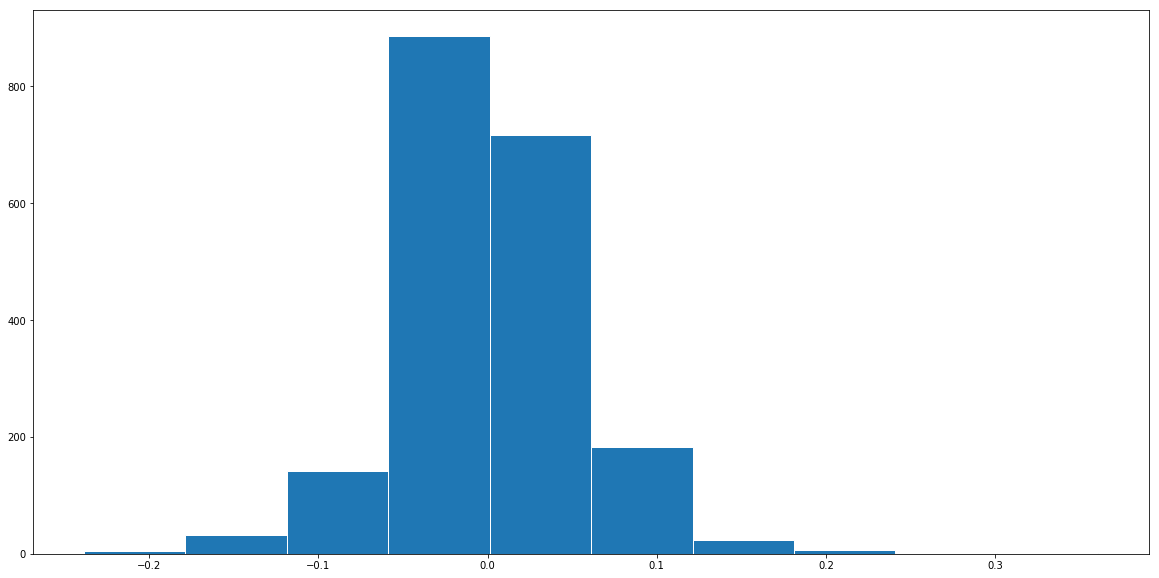

In [852]:
plt.figure(figsize=(20,10))
plt.hist(y,ec = 'white')
plt.show();

In [986]:
fixed_x = []
'''
for date in x:
    for neigh_bd in date:
        fixed_x.append(neigh_bd)
print(len(fixed_x))
print(len(y))
'''
train_x = x[:-200]
train_y = y[:-200]

test_x = x[-200:]
test_y = y[-200:]

print(len(train_y), len(train_x))

TypeError: 'int' object is not subscriptable

In [985]:
print(len(x), len(y))

TypeError: object of type 'int' has no len()

In [882]:
import scipy.stats as stats

for i in range(len(fixed_x[0])):
    
    print(stats.pearsonr([z[i] for z in fixed_x], y))


(0.008214615369011464, 0.7138536264704743)
(0.17843677550797107, 9.788707712982072e-16)
(-0.055790555906710865, 0.012692300888368903)
(-0.02386186946988784, 0.2867473519784577)
(-0.05922677518091128, 0.008143683718247223)
(-0.03990637804559177, 0.07474467356705543)
(-0.021971288615074643, 0.3266616715412515)
(-0.024258741304696293, 0.2788052232022488)
(-0.031454445921307146, 0.16020183039343208)
(-0.019791236975492045, 0.3769572907830653)
(0.014708205634449547, 0.5114561596874528)
(0.027965167852657558, 0.21183433423382517)
(-0.0258594379947878, 0.24829856692921873)
(-0.020252730737304638, 0.3659304192626711)
(-0.00997307321673301, 0.6561872093202278)
(-0.01142765953956771, 0.609968798004373)
(0.0036039142056001955, 0.8721958015659237)
(-0.015710780774323776, 0.48309575892136214)
(0.00682219889839232, 0.7607249312522382)
(-0.022836826417211818, 0.30796082927589125)
(-0.04052843088788553, 0.0703223826722934)
(-0.013026755357382758, 0.560899786396369)
(-0.018742945542938382, 0.4027553751

In [928]:
  
for i in range(len(new_x[0])):
    print(stats.pearsonr([z[i] for z in new_x], new_y))
    

(-0.14809442596601108, 0.02633022055585529)
(-0.04286899106102411, 0.5223367884332627)
(0.0035608576076970816, 0.95763985570623)
(0.035657835815821846, 0.5946860514370217)
(0.01290383977758488, 0.8473603332563655)
(0.08924562226328289, 0.18223947123218845)
(0.020773715340422248, 0.756634269679616)
(-0.01763422358389167, 0.7925039309811996)
(-0.06671239789339263, 0.3191419911197837)
(-0.02307246455124917, 0.730692002514497)
(-0.11810171175484452, 0.07708586885445118)
(0.13206495035988772, 0.04785931673291751)
(0.07891501752878663, 0.23840944621554588)
(0.021556778755714295, 0.7477647978358716)
(0.03897578913630702, 0.5608350810295345)
(0.07510755964543449, 0.26189483989920653)
(0.026414386389495004, 0.6935236564026334)
(0.001940798473279064, 0.9769045829751464)
(0.011449470782074438, 0.8643880359284236)
(-0.008368494209223741, 0.9006577925080285)
(-0.030416586644858613, 0.6499637084773315)
(-0.03906187872229593, 0.5599692404502546)
(0.0714706158063668, 0.2857669830219695)
(0.07537814852

In [776]:
for i in np.arange(0,1601,50):
    total_r = 0
    for j in range(len(fixed_x[0])):
        #print()
        r,p = stats.pearsonr([z[j] for z in fixed_x[i:i+20]], y[i:i+20])
        #print("R vals: ",r)
        total_r += np.abs(r)
    
    print(total_r/14)

0.33836681511438643
0.2828905655067229
0.25411233612828105
0.2540003770330325
0.442577899214696
0.33682456546626705
0.24892204053797445
0.2870130527061064
0.2271703778389099
0.39556621179041024
0.40863079461694657
0.24734828149935953
0.30957679110039876
0.21558366163711318
0.3316668696200395
0.36656608876529984
0.3598507722801841
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [854]:

for i in range(len(fixed_x[0])):
    print([z[i] for z in fixed_x])
    #plt.figure(figsize=(14,8))
    #plt.hist([z[i] for z in fixed_x], ec = 'white')
    #plt.show();

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [481]:
def classifier_accuracy(clf, test_x, test_y):
    results = clf.predict(test_x)
    tot_wrong = 0
    #print(test_y, results)
    for y, y_hat in zip(test_y, results):
        #print(y,y_hat)
        if np.sign(y) != np.sign(y_hat):
            tot_wrong += 1
    return (tot_wrong/len(test_y))

In [984]:
y_class_cutoffs = [-0.03, 0.04, 1]
y_classes = [-1,0,1]

class_ys = convert_regression_ys_to_classes(y, y_class_cutoffs, y_classes)
train_class_ys = class_ys[:-200]
test_class_ys = class_ys[-200:]
print(len(train_class_ys), len(train_x))
plt.hist(class_ys,ec = "white");

TypeError: 'int' object is not iterable

In [975]:
train_y = np.array(train_y)
train_x = np.array(train_x)
train_class_ys = np.array(train_class_ys)
test_x = np.array(test_x)
test_y = np.array(test_y)
test_class_ys = np.array(test_class_ys)

In [889]:
from sklearn.ensemble import RandomForestClassifier

train_error = 0
test_error = 0
for i in range(100):
    clf_tree = RandomForestClassifier(n_estimators=1000, max_depth=1, random_state=0)
    clf_tree.fit(train_x, train_class_ys)
    train_error += classifier_accuracy(clf_tree, train_x, train_class_ys)
    test_error += classifier_accuracy(clf_tree, test_x, test_class_ys)
print("Depth = ", 1)
print("train error = ", train_error/100)
print("test error = ", test_error/100)

train_error = 0
test_error = 0
for i in range(100):
    clf_tree = RandomForestClassifier(n_estimators=1000, max_depth=11, random_state=0)
    clf_tree.fit(train_x, train_class_ys)
    train_error += classifier_accuracy(clf_tree, train_x, train_class_ys)
    test_error += classifier_accuracy(clf_tree, test_x, test_class_ys)
print("Depth = ", 11)
print("train error = ", train_error/100)
print("test error = ", test_error/100)
    
train_error = 0
test_error = 0
for i in range(100):
    clf_tree = RandomForestClassifier(n_estimators=1000, max_depth=21, random_state=0)
    clf_tree.fit(train_x, train_class_ys)
    train_error += classifier_accuracy(clf_tree, train_x, train_class_ys)
    test_error += classifier_accuracy(clf_tree, test_x, test_class_ys)
print("Depth = ", 21)
print("train error = ", train_error/100)
print("test error = ", test_error/100)

Depth =  1
train error =  0.6590529247910853
test error =  0.6400000000000005
Depth =  11
train error =  0.09805013927576609
test error =  0.6099999999999995
Depth =  21
train error =  0.0
test error =  0.6049999999999988


In [983]:
clf_tree = RandomForestClassifier(n_estimators=10000, max_depth=11)
clf_tree.fit(train_x, train_class_ys)
pred_y = clf_tree.predict(test_x)
print(classifier_accuracy(clf_tree, train_x, train_class_ys))
print(classifier_accuracy(clf_tree, test_x, test_class_ys))
for y, y_pred in zip(test_class_ys, pred_y):
    print(y, y_pred)

0.013605442176870748
0.47
-1 0
0 0
0 0
-1 0
0 0
1 0
0 0
-1 0
0 0
0 0
-1 0
-1 0
0 0
-1 0
1 0
1 0
1 0
0 0
-1 0
0 0
0 0
0 0
0 0
1 0
1 0
-1 0
1 0
0 0
0 0
1 0
0 0
1 0
1 1
0 0
0 0
-1 0
0 0
-1 0
0 0
1 0
-1 0
0 0
-1 0
0 0
0 0
0 0
0 0
0 0
-1 0
0 0
1 0
1 0
-1 0
0 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
-1 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
1 0
0 0
0 0
-1 0
1 0
1 0
0 0
0 0
0 0
1 1
1 0
-1 0
1 0
0 0
0 0
0 0
0 0
-1 0
-1 0
0 0
0 0
0 0
1 0
1 0
1 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
-1 0
0 0
0 0
0 0
1 0
-1 0
0 0
-1 0
1 0
1 0
0 0
1 0
0 0
0 0
0 0
1 0
-1 0
1 0
1 0
0 0
0 0
-1 0
0 0
1 0
1 0
-1 0
-1 0
-1 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
-1 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
1 0
0 0
-1 0
1 0
0 0
0 0
-1 0
0 0
0 0
0 0
-1 0
1 0
0 0
0 0
1 0
0 0
1 0
1 0
0 0
1 0
1 0
0 0
0 0
0 0
-1 0
1 0
1 0
0 0
1 1
0 0
1 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
-1 0


In [895]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
clf_ridge = Ridge(alpha=0.1)
clf_ridge.fit(train_x, train_y) 
pred_y = clf_ridge.predict(test_x)
print(mean_squared_error(test_y, pred_y))
print(test_y, pred_y)

0.001674362465166987
[-0.00151515 -0.07614213  0.00664653  0.03422371  0.00166945 -0.02211874
  0.         -0.01234568 -0.04661654 -0.02083333  0.10357143  0.
 -0.0204918   0.03244838  0.0975      0.04746318  0.00203252 -0.03311258
 -0.01960784  0.00576631 -0.00797774 -0.00217729  0.0488677   0.03174603
 -0.09449082  0.06704871  0.          0.00182149  0.04255319  0.07837838
  0.04829787  0.          0.02808989 -0.03392857  0.01449275 -0.03588369
  0.02912621  0.03030303 -0.04761905 -0.01981132 -0.04006678 -0.00185185
  0.0031348   0.01492537  0.00045475 -0.015      -0.04469274 -0.01334212
  0.04311544  0.03820045 -0.03049505 -0.00577664  0.04761905  0.09038737
  0.1         0.00878735  0.01098901  0.02222222  0.01522843 -0.00421295
 -0.01284404  0.07612688 -0.00877193  0.         -0.02392947  0.08441665
  0.00143062 -0.01836238  0.04806452 -0.00348944  0.02671119 -0.01333333
  0.07        0.02539113  0.         -0.06542056  0.06060606  0.04166667
  0.0164076   0.02653981  0.02380952  

In [492]:
clf_ridge = Ridge(alpha=0.1)
clf_ridge.fit(train_x, train_y) 
pred_y = clf_ridge.predict(train_x)
print(mean_squared_error(train_y, pred_y))

0.002642497334215103


In [498]:
import numpy as np
from numpy import linalg

def linear_kernel(x1, x2):
    out = np.dot(x1,x2)
    return out
    
def polynomial_kernel(x, y, p = 3):
    out = (1 + np.dot(x,y))**p
    return out 
    
def gaussian_kernel(x, y, sigma = 0.5):
    out = np.exp(-((linalg.norm(x-y))**2)/(2*sigma**2))
    return out 

class KernelPerceptron:
    def __init__(self, kernel = linear_kernel, Niter = 1):
        
        self.kernel = kernel
        self.Niter = Niter
        self.alphas = None
        self.training_x = None
        self.training_y = None
    
    def shuffle_data(self):
        shuff = np.arange(self.training_x.shape[0])
        np.random.shuffle(shuff)
        self.training_x = self.training_x[shuff,:]
        self.training_y = self.training_y[shuff]
        self.alphas = self.alphas[shuff]
        return self.training_x, self.training_y
    

    def fit(self, X, y):
        self.alphas = np.zeros(X.shape[0])
        self.training_x = X
        self.training_y = y
        forward_back_i = list(range(min(self.Niter, len(X))))
        forward_back_i.extend(reversed(list(range(min(self.Niter, len(X))))))
        X, y = self.shuffle_data()
        for i in forward_back_i:
            summation = 0
            for j,a in enumerate(self.alphas):
                summation += a*y[j]*self.kernel(X[j],X[i])
            result = y[i]*summation
            if result <= 0:
                self.alphas[i] += 1 
    
    def predict(self, X):
        summation = 0
        y_pred = []
        for x in X:
            summation = 0
            for j,a in enumerate(self.alphas):
                summation += a*self.training_y[j]*self.kernel(self.training_x[j],x)
            y = np.sign(summation)
            y_pred.append(y)
        return np.array(y_pred)

In [563]:
results_test = []
for k,name in zip([linear_kernel, polynomial_kernel, gaussian_kernel], ['linear_kernel', 'polynomial_kernel', 'gaussian_kernel']):
    print(name)
    all_test_acc = []
    all_train_acc = []
    for z in range(5):
        print(z)
        test = KernelPerceptron(kernel = k, Niter = len(train_x))
        test.fit(train_x, train_class_ys)
        y_pred = test.predict(train_x)
        train_acc = np.sum((y_pred == train_class_ys))/len(train_class_ys)
        y_pred_test = test.predict(test_x)
        test_acc = np.sum((y_pred_test == test_class_ys))/len(test_class_ys)
        all_train_acc.append(train_acc)
        all_test_acc.append(test_acc)
        
    results_test.append((name,all_test_acc))

linear_kernel
0
1
2
3
4
polynomial_kernel
0
1
2
3
4
gaussian_kernel
0
1
2
3


KeyboardInterrupt: 

In [890]:
results_test = []
for k,name in zip([polynomial_kernel, gaussian_kernel], ['polynomial_kernel', 'gaussian_kernel']):
    print(name)
    all_test_acc = []
    all_train_acc = []
    for z in range(5):
        print(z)
        test = KernelPerceptron(kernel = k, Niter = len(train_x))
        test.fit(train_x, train_class_ys)
        y_pred = test.predict(train_x)
        train_acc = np.sum((y_pred == train_class_ys))/len(train_class_ys)
        y_pred_test = test.predict(test_x)
        test_acc = np.sum((y_pred_test == test_class_ys))/len(test_class_ys)
        all_train_acc.append(train_acc)
        all_test_acc.append(test_acc)
        
    results_test.append((name,all_train_acc,all_test_acc))

polynomial_kernel
0
1
2
3
4
gaussian_kernel
0
1
2
3
4


In [891]:
for name, train_acc, test_acc in results_test:
    print("Kernel: %s"%name)
    print("Average Percent Train Error: %.2f"%(100-np.mean(train_acc)*100))
    print("Average Percent Test Error: %.2f"%(100-np.mean(test_acc)*100))

Kernel: polynomial_kernel
Average Percent Train Error: 81.07
Average Percent Test Error: 84.30
Kernel: gaussian_kernel
Average Percent Train Error: 68.68
Average Percent Test Error: 74.40


In [987]:
from sklearn.multiclass import OneVsRestClassifier

new_clf =  RandomForestClassifier(n_estimators=10000, max_depth=11)
OVR = OneVsRestClassifier(new_clf)
OVR.fit(train_x, train_class_ys)
print(classifier_accuracy(OVR, train_x, train_class_ys))
print(classifier_accuracy(OVR, test_x, test_class_ys))
pred_y = OVR.predict(test_x)
for y, y_pred in zip(test_class_ys, pred_y):
    print(y, y_pred)

0.001943634596695821
0.485
-1 0
0 0
0 0
-1 0
0 0
1 0
0 0
-1 0
0 0
0 0
-1 0
-1 0
0 0
-1 0
1 0
1 0
1 0
0 0
-1 0
0 0
0 0
0 0
0 0
1 0
1 0
-1 0
1 0
0 1
0 0
1 0
0 0
1 0
1 1
0 0
0 -1
-1 0
0 0
-1 0
0 0
1 0
-1 0
0 0
-1 0
0 0
0 0
0 0
0 0
0 0
-1 0
0 0
1 0
1 0
-1 0
0 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
-1 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
1 0
0 0
0 0
-1 0
1 0
1 0
0 0
0 0
0 0
1 1
1 0
-1 0
1 0
0 0
0 0
0 0
0 0
-1 0
-1 0
0 0
0 0
0 1
1 0
1 0
1 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
-1 0
0 0
0 0
0 0
1 0
-1 0
0 0
-1 0
1 0
1 0
0 0
1 0
0 0
0 0
0 0
1 0
-1 0
1 0
1 0
0 0
0 0
-1 0
0 0
1 0
1 0
-1 0
-1 0
-1 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
-1 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
1 0
0 0
-1 0
1 0
0 0
0 0
-1 0
0 0
0 0
0 0
-1 0
1 0
0 0
0 0
1 0
0 0
1 0
1 0
0 0
1 0
1 1
0 0
0 0
0 0
-1 0
1 0
1 0
0 0
1 1
0 0
1 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 1
0 0
-1 0


In [988]:
three_months = get_date_pairs(3, airbnb_files, airbnb_files_monthyear)

42


In [989]:

print("CURR CONDITIONS: ")
print((3, 3, 3))
all_results_conditions.append((3, 3, 3))
x,y = create_labeled_set_regression(three_months,zillow_files,desired_col,desired_col_aggregate_quants, 3, 3)
df = pd.DataFrame(x,columns = Feature_Column_Names)
df['y'] = y
file_name = "output/labeled_set_abnbLag%i_zLag%i_monPred%i.csv"%(3, 3, 3)
df.to_csv(file_name)
all_results.append(df)

CURR CONDITIONS: 
(3, 3, 3)
('2015_03.csv', '2015_06.csv') 2015_06 2015_09
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (26,65) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


75 75
('2015_05.csv', '2015_08.csv') 2015_08 2015_11
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


149 149
('2015_06.csv', '2015_09.csv') 2015_09 2015_12
found
224 224
('2015_08.csv', '2015_11.csv') 2015_11 2016_02
found
300 300
('2015_09.csv', '2015_12.csv') 2015_12 2016_03
found
375 375
('2015_10.csv', '2016_01.csv') 2016_01 2016_04
found
451 451
('2015_11.csv', '2016_02.csv') 2016_02 2016_05
found
529 529
('2016_01.csv', '2016_04.csv') 2016_04 2016_07
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (40,85) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


610 610
('2016_02.csv', '2016_05.csv') 2016_05 2016_08
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


690 690
('2016_04.csv', '2016_07.csv') 2016_07 2016_10
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


771 771
('2016_05.csv', '2016_08.csv') 2016_08 2016_11
found
853 853
('2016_06.csv', '2016_09.csv') 2016_09 2016_12
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


939 939
('2016_07.csv', '2016_10.csv') 2016_10 2017_01
found
1023 1023
('2016_08.csv', '2016_11.csv') 2016_11 2017_02
found
1107 1107
('2016_09.csv', '2016_12.csv') 2016_12 2017_03
found
1193 1193
('2016_10.csv', '2017_01.csv') 2017_01 2017_04
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1281 1281
('2016_11.csv', '2017_02.csv') 2017_02 2017_05
found
1367 1367
('2016_12.csv', '2017_03.csv') 2017_03 2017_06
found
1456 1456
('2017_01.csv', '2017_04.csv') 2017_04 2017_07
found
1544 1544
('2017_02.csv', '2017_05.csv') 2017_05 2017_08
found
1632 1632
('2017_03.csv', '2017_06.csv') 2017_06 2017_09
found
1722 1722
('2017_04.csv', '2017_07.csv') 2017_07 2017_10
found
1812 1812
('2017_05.csv', '2017_08.csv') 2017_08 2017_11
found
1902 1902
('2017_06.csv', '2017_09.csv') 2017_09 2017_12
found
1991 1991
('2017_07.csv', '2017_10.csv') 2017_10 2018_01
found
2083 2083
('2017_08.csv', '2017_11.csv') 2017_11 2018_02
found
2178 2178
('2017_09.csv', '2017_12.csv') 2017_12 2018_03
found
2269 2269
('2017_10.csv', '2018_01.csv') 2018_01 2018_04
found
2362 2362
('2017_11.csv', '2018_02.csv') 2018_02 2018_05
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,62,77,78,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2458 2458
('2017_12.csv', '2018_03.csv') 2018_03 2018_06
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,62,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2557 2557
('2018_01.csv', '2018_04.csv') 2018_04 2018_07
found
2654 2654
('2018_02.csv', '2018_05.csv') 2018_05 2018_08
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,61,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2753 2753
('2018_03.csv', '2018_06.csv') 2018_06 2018_09
found


/Users/astrangedoor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2852 2852
('2018_04.csv', '2018_07.csv') 2018_07 2018_10
('2018_05.csv', '2018_08.csv') 2018_08 2018_11
('2018_06.csv', '2018_09.csv') 2018_09 2018_12
('2018_07.csv', '2018_10.csv') 2018_10 2019_01
